In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation
from collections import Counter
from keras.layers import LSTM, Dense, Embedding, MaxPooling1D, Conv1D, Dropout, SpatialDropout1D
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint

In [25]:
data = pd.read_csv('spambase.csv')
data.shape
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [34]:
def preprocessor_dataset_spam(spam_data):
    spam_data['text'] = spam_data['text'].apply(lambda x: str(x).lower())
    spam_data['text'] = spam_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    spam_data['target'] = spam_data['target'].map({'ham': 0, 'spam': 1})
    spam_data.head(10)
    return spam_data

def preprocessor_dataset_tokenizer(spam_data, max_features=2000, delimiter=' '):
    tokenizer = Tokenizer(num_words=max_features, split=delimiter)
    tokenizer.fit_on_texts(spam_data['text'].values)
    X = pad_sequences(tokenizer.texts_to_sequences(spam_data['text'].values))
    y = pd.get_dummies(spam_data['target']).values
    return X, y

def get_lstm_model(config_json, verbose=True):
    model = Sequential()
    model.add(Embedding(config_json['max_features'], 
                      config_json['embedding_len'], 
                      input_length=config_json['input_len']))
    model.add(SpatialDropout1D(0.6))
    model.add(LSTM(config_json['output_lstm_dim'], dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(config_json['classes'], activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',
                metrics = ['accuracy'])
  
    if verbose:
        print(model.summary())

    return model

In [35]:
X=data.drop(columns=['spam'])
y=data['spam']
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, random_state=8) 

In [36]:
print(X.shape, y.shape)

(4601, 57) (4601,)


In [37]:
print(X.shape[1])
print(X.shape[0])

57
4601


In [38]:
config = {
    'input_len': X.shape[1],
    'max_features': 100000,
    'embedding_len': 128,
    'output_lstm_dim': 200,
    'classes': 1
}
model = get_lstm_model(config)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 57, 128)           12800000  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 57, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 200)               263200    
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 13,063,401
Trainable params: 13,063,401
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
batch_size = 128
checkpoint = ModelCheckpoint('model_checkpoint.h5',
                             monitor='loss',
                             verbose=1,
                             save_best_only=True, mode='min')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = batch_size)
y_pred = model.predict(X_test)

Epoch 1/20
31/31 [==============================] - 21s 545ms/step - loss: 0.6623 - accuracy: 0.6056 - val_loss: 0.6466 - val_accuracy: 0.5962
Epoch 2/20
31/31 [==============================] - 16s 527ms/step - loss: 0.6013 - accuracy: 0.6537 - val_loss: 0.5531 - val_accuracy: 0.7265
Epoch 3/20
31/31 [==============================] - 16s 526ms/step - loss: 0.4942 - accuracy: 0.7747 - val_loss: 0.4602 - val_accuracy: 0.7844
Epoch 4/20
31/31 [==============================] - 16s 525ms/step - loss: 0.3920 - accuracy: 0.8304 - val_loss: 0.3914 - val_accuracy: 0.8162
Epoch 5/20
31/31 [==============================] - 16s 525ms/step - loss: 0.3611 - accuracy: 0.8404 - val_loss: 0.3759 - val_accuracy: 0.8307
Epoch 6/20
31/31 [==============================] - 16s 526ms/step - loss: 0.3406 - accuracy: 0.8529 - val_loss: 0.3537 - val_accuracy: 0.8480
Epoch 7/20
31/31 [==============================] - 16s 524ms/step - loss: 0.3205 - accuracy: 0.8624 - val_loss: 0.3479 - val_accuracy: 0.8452

In [40]:
def transform_predict(message: list):
    return pad_sequences(tokenizer.texts_to_sequences(message), maxlen=28, dtype='int32', value=0) 
  
def predict(X):
    X = transform_predict(X)
    return model.predict(X)[0]

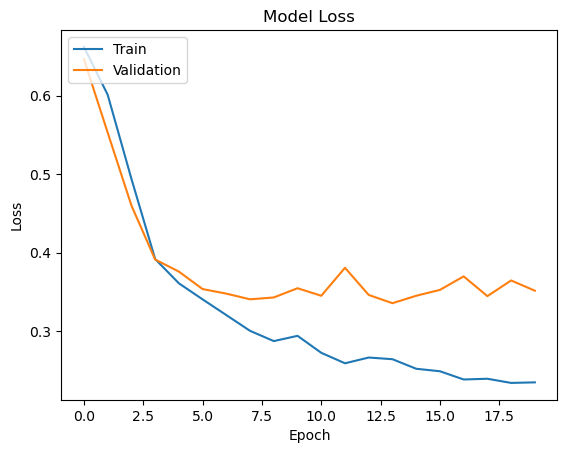

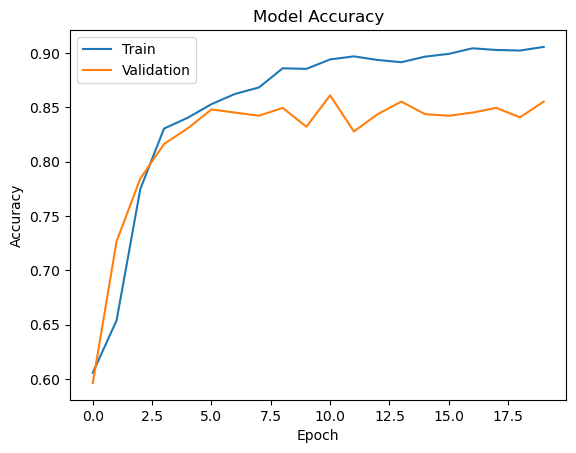

In [41]:
# # LSTM Learning Curve:
def plot_learning_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the learning curve
plot_learning_curve(history)

In [48]:
X=data.drop(columns=['spam'])
y=data['spam']
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, random_state=8) 

In [53]:
model = Sequential()
model.add(InputLayer(input_shape=(X.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

y_pred = model.predict(X_test)

Epoch 1/20
123/123 [==============================] - 2s 7ms/step - loss: 7.5421 - accuracy: 0.5767 - val_loss: 4.0934 - val_accuracy: 0.5658
Epoch 2/20
123/123 [==============================] - 0s 4ms/step - loss: 3.6605 - accuracy: 0.6742 - val_loss: 0.9670 - val_accuracy: 0.7279
Epoch 3/20
123/123 [==============================] - 0s 4ms/step - loss: 1.7363 - accuracy: 0.7187 - val_loss: 0.5084 - val_accuracy: 0.7887
Epoch 4/20
123/123 [==============================] - 0s 4ms/step - loss: 1.1171 - accuracy: 0.7409 - val_loss: 0.4907 - val_accuracy: 0.7164
Epoch 5/20
123/123 [==============================] - 0s 4ms/step - loss: 0.8235 - accuracy: 0.7437 - val_loss: 0.4994 - val_accuracy: 0.7091
Epoch 6/20
123/123 [==============================] - 1s 4ms/step - loss: 0.6678 - accuracy: 0.7545 - val_loss: 0.4512 - val_accuracy: 0.7381
Epoch 7/20
123/123 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.7675 - val_loss: 0.4754 - val_accuracy: 0.7120
Epoch 

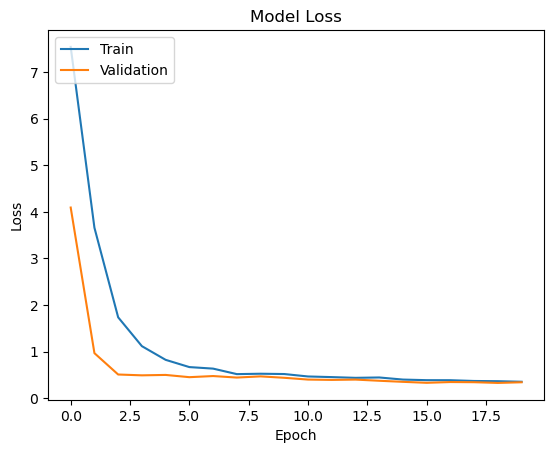

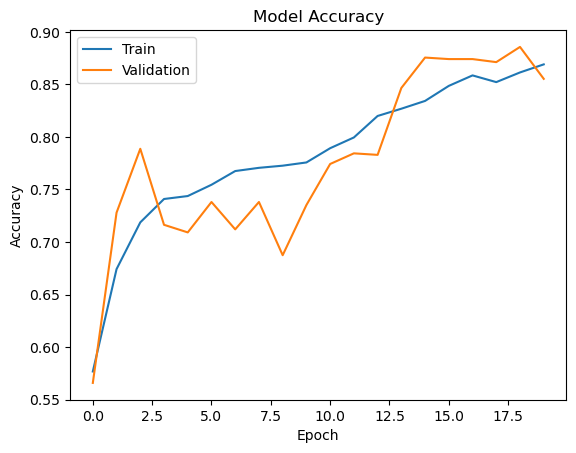

In [55]:
def plot_learning_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the learning curve
plot_learning_curve(history)